# Convolution Nets for MNIST

Deep Learning models can take quite a bit of time to run, particularly if GPU isn't used. 

In the interest of time, you could sample a subset of observations (e.g. $1000$) that are a particular number of your choice (e.g. $6$) and $1000$ observations that aren't that particular number (i.e. $\neq 6$). 

We will build a model using that and see how it performs on the test dataset

In [1]:
#Import the required libraries
import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
from keras.models import Sequential

In [3]:
from keras.layers.core import Dense, Dropout, Activation, Flatten

In [4]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [5]:
from keras.utils import np_utils
from keras.optimizers import SGD

## Loading Data

In [6]:
import pickle
import gzip
import sys

def load_mnist_local(path):
    if path.endswith(".gz"):
        f = gzip.open(path, 'rb')
    else:
        f = open(path, 'rb')

    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding="bytes")

    f.close()
    return data

path_to_dataset = "data/mnist.pkl.gz"
(X_train, y_train), (X_test, y_test) = load_mnist_local(path_to_dataset)

In [7]:
# Backup of the data
X_test_orig = X_test

## Data Preparation

In [8]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data
X_train /= 255
X_test /= 255


For the sake of simplicity, we want to distinguish a 6 among all 10 numbers now.

In [9]:
# Seed for reproducibilty
np.random.seed(1338)

# Test data
X_test = X_test.copy()
Y = y_test.copy()

# Converting the output to binary classification(Six=1,Not Six=0)
Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()

# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]

In [11]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape(X_six.shape[0] + X_not_six.shape[0], 
                          1, img_rows, img_cols)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [12]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)
#  4 Dimensions -> 12.000 images, black/white i.e. color dimensionality (0), 28x28 (resolution)

(11918, 1, 28, 28) (11918,) (10000, 1, 28, 28) (10000,)


In [13]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

# A simple CNN

In [15]:
#Initializing the values for the convolution neural network
nb_epoch = 2
batch_size = 128
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling -> shape of max pool filter: 2x2
nb_pool = 2
# convolution kernel size: 3x3
nb_conv = 3

# stochastic gradient descent
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

### Step 1: Model Definition

In [17]:
model = Sequential()

# We add convolution 2D model (because images are 2 dimensional), Number of convultions (nb_filters), size of the
# convolutions

# "channels_first" -> first dimensions are colors
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), data_format="channels_first", input_shape=(1,img_rows, img_cols)))

# now we use the relu function
model.add(Activation('relu'))

# reshapes convolutional image to a vectors
model.add(Flatten())

# this vector is passed to a dense layer
model.add(Dense(nb_classes))

# after that we add a softmax function: output probability of 6 versus not 6
model.add(Activation('softmax'))

### Step 2: Compile

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### Step 3: Fit

In [19]:
model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 10130 samples, validate on 1788 samples
Epoch 1/2
10130/10130 [==============================] - 40s - loss: 0.3718 - acc: 0.8732 - val_loss: 0.2611 - val_acc: 0.9318
Epoch 2/2
10130/10130 [==============================] - 39s - loss: 0.1635 - acc: 0.9553 - val_loss: 0.1493 - val_acc: 0.9564


### Step 4: Evaluate

In [20]:
# Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.166167336679
Test accuracy: 0.9514


### Let's plot our model Predictions!

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

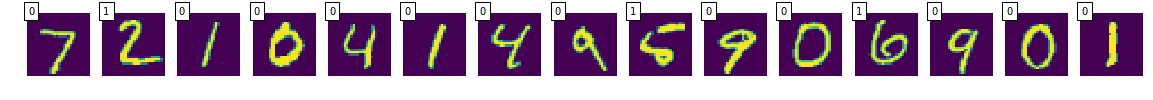

In [23]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(20,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

# Adding more Dense Layers

In [24]:
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv),
                        data_format="channels_first",
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 10130 samples, validate on 1788 samples
Epoch 1/2
10130/10130 [==============================] - 56s - loss: 0.3595 - acc: 0.8565 - val_loss: 0.1692 - val_acc: 0.9670
Epoch 2/2
10130/10130 [==============================] - 50s - loss: 0.1381 - acc: 0.9600 - val_loss: 0.1168 - val_acc: 0.9681


In [26]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.13640705694
Test accuracy: 0.9594


# Adding Dropout

In [27]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv),
                        data_format="channels_first",
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

# Here we add the Dropout, removes randomly the units of this layer (for the sake of performance, averages the units)
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 10130 samples, validate on 1788 samples
Epoch 1/2
10130/10130 [==============================] - 11s - loss: 0.3702 - acc: 0.8647 - val_loss: 0.2255 - val_acc: 0.9463

In [25]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.114496421862
Test accuracy: 0.9628


# Adding more Convolution Layers

In [28]:
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv),
                        data_format="channels_first",
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch, verbose=1)

Epoch 1/2
11918/11918 [==============================] - 100s - loss: 0.5385 - acc: 0.8066   
Epoch 2/2
11918/11918 [==============================] - 111s - loss: 0.2413 - acc: 0.9256   


In [28]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.119200739402
Test accuracy: 0.9619


# Fun time! :-)
Let's play with the CNN above in your browser with `keras.js`. Open this [link](https://transcranial.github.io/keras-js/#/mnist-cnn) in your browser!

# Exercise

The above code has been written as a function. 

Change some of the **hyperparameters** and see what happens. 

In [71]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model():
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), data_format="channels_first",                       
                        input_shape=(1, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1, validation_split=0.15)
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)

In [72]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 10130 samples, validate on 1788 samples
Epoch 1/2
10130/10130 [==============================] - 20s - loss: 0.5355 - acc: 0.7592 - val_loss: 0.4214 - val_acc: 0.8691

# Batch Normalisation

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

## How to BatchNorm in Keras

```python
from keras.layers.normalization import BatchNormalization

BatchNormalization(epsilon=1e-06, mode=0, 
                   axis=-1, momentum=0.99, 
                   weights=None, beta_init='zero', 
                   gamma_init='one')
```

In [33]:
# Try to add a new BatchNormalization layer to the Model 
# (after the Dropout layer)


In [39]:
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), data_format="channels_first", 
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 26s - loss: 0.2321 - acc: 0.9163 - val_loss: 0.4573 - val_acc: 0.9376
Epoch 2/2
11918/11918 [==============================] - 30s - loss: 0.1001 - acc: 0.9656 - val_loss: 0.3006 - val_acc: 0.9675


# Few notes on optimizers
Keras support many optimizers (SGD, Adagrad, Adama, RMSprop, etc.). 
The optimization procedure controls the way in which the parameters of the model are updated during the training and play an important role in controlling the stability of learning and prevent over- and under-fitting.

For further details, I strongly encourage you to check Sebastian Ruder's blog post "An overview of gradient descent optimization" [link](http://sebastianruder.com/optimizing-gradient-descent/)

In [48]:
from keras import optimizers
dir(optimizers)

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'K',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'absolute_import',
 'adadelta',
 'adagrad',
 'adam',
 'adamax',
 'clip_norm',
 'get',
 'get_from_module',
 'nadam',
 'optimizer_from_config',
 'rmsprop',
 'sgd',
 'zip']

`optimizer` is one of the required arguments of `model.compile` and allows to control the optimization process.
You can set the optimizer by:
- calling it by its __name__; this way the optimizer is initialzed to its __default__ values
- create a __custom__ optmizer

In [49]:
# for example, here we compile the model with adagrad set to its default values
model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          nb_epoch=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 28s - loss: 0.1436 - acc: 0.9799 - val_loss: 0.0441 - val_acc: 0.9859
Epoch 2/2
11918/11918 [==============================] - 32s - loss: 0.0280 - acc: 0.9900 - val_loss: 0.1469 - val_acc: 0.9528


In [51]:
from keras.optimizers import Adagrad
# here we use a custom optimizerinstead
opt = Adagrad(lr=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          nb_epoch=nb_epoch,verbose=1,
          validation_split=0.15)

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 30s - loss: 0.0943 - acc: 0.9854 - val_loss: 0.0278 - val_acc: 0.9930
Epoch 2/2
11918/11918 [==============================] - 30s - loss: 0.0244 - acc: 0.9930 - val_loss: 0.0208 - val_acc: 0.9956


In [ ]:
# Now it is your turn! Try with other optimizers